In [52]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
DATASET_PATH = '/kaggle/input/brats2020-training-data/'

In [54]:
import pandas as pd
import os

pd.set_option('display.max_colwidth', None)  # Show full text
df = pd.read_csv(os.path.join(DATASET_PATH, 'BraTS20 Training Metadata.csv'))

df["slice_path"] = df["slice_path"].str[2:] 
df["slice_path"] = "/kaggle" + df["slice_path"] 

df.sample(n = 10)

,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio
55312,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_137_slice_132.h5,0,137,132,0,0,0,1.000000
46010,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_68_slice_130.h5,0,68,130,0,0,0,1.000000
35090,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_142_slice_60.h5,0,142,60,0,0,0,1.000000
51166,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_194_slice_16.h5,0,194,16,0,0,0,1.000000
18418,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_300_slice_128.h5,1,300,128,158,366,0,0.990903
26904,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_340_slice_89.h5,1,340,89,820,512,958,0.960243
25724,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_349_slice_149.h5,0,349,149,0,0,0,1.000000
50613,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_196_slice_83.h5,1,196,83,0,2765,0,0.951997
55930,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_335_slice_130.h5,0,335,130,0,0,0,1.000000
30340,/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_24_slice_115.h5,1,24,115,4,170,73,0.995712


In [55]:
## Calculating class imbalance

background_percentage = 100 * sum(df["background_ratio"]) / len(df["background_ratio"])
print(f"Background Percentage: {background_percentage:.2f}%")


Background Percentage: 98.89%


In [56]:
import numpy as np


def normalize_image(image):
    """Normalize each MRI modality independently using Z-score normalization."""
    normalized_image = np.zeros_like(image, dtype=np.float32)
    
    for i in range(image.shape[-1]):  # Loop over modalities (T1, T2, etc.)
        modality = image[..., i]
        mean, std = np.mean(modality), np.std(modality)
        
        if std > 0:
            normalized_image[..., i] = (modality - mean) / std
        else:
            normalized_image[..., i] = modality  # Avoid division by zero
    
    return normalized_image
    
def one_hot_encode(mask):
    """Convert segmentation mask to one-hot encoding (binary per class)."""
    one_hot_mask = np.zeros((*mask.shape[:2], 3))  # Shape: (240, 240, 3)
    for i in range(3):
        one_hot_mask[:, :, i] = (mask[:, :, i] > 0).astype(np.uint8)
    return one_hot_mask

def mask_to_class(mask):
    """Convert multi-channel mask to class indices."""
    # Convert from (height, width, num_classes) to (height, width)
    return np.argmax(mask, axis=1)

Sample Number: 37490
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)


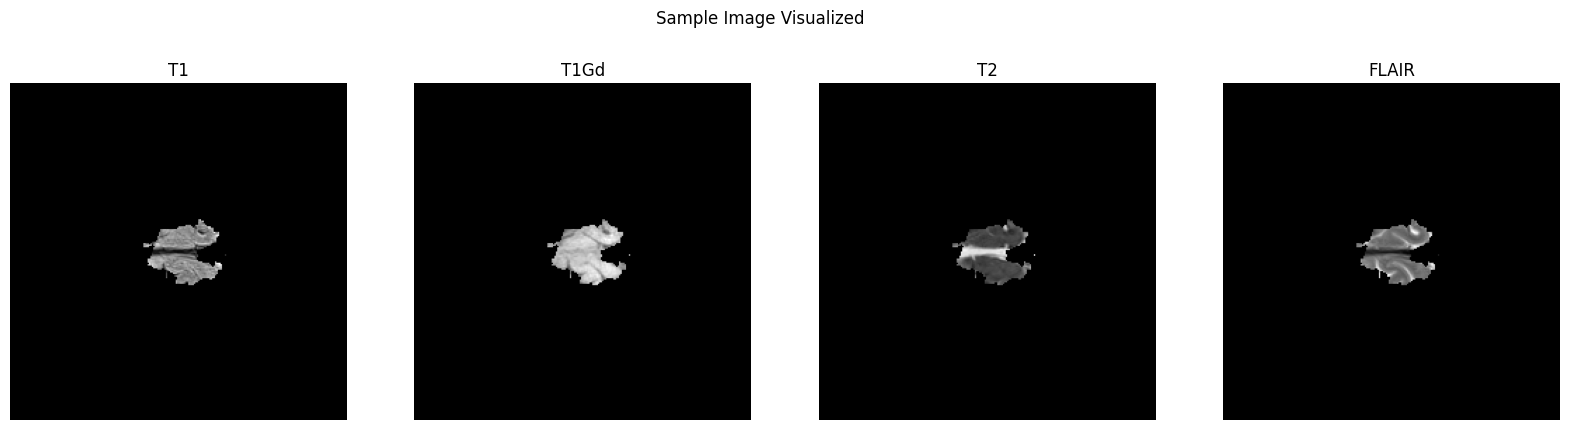

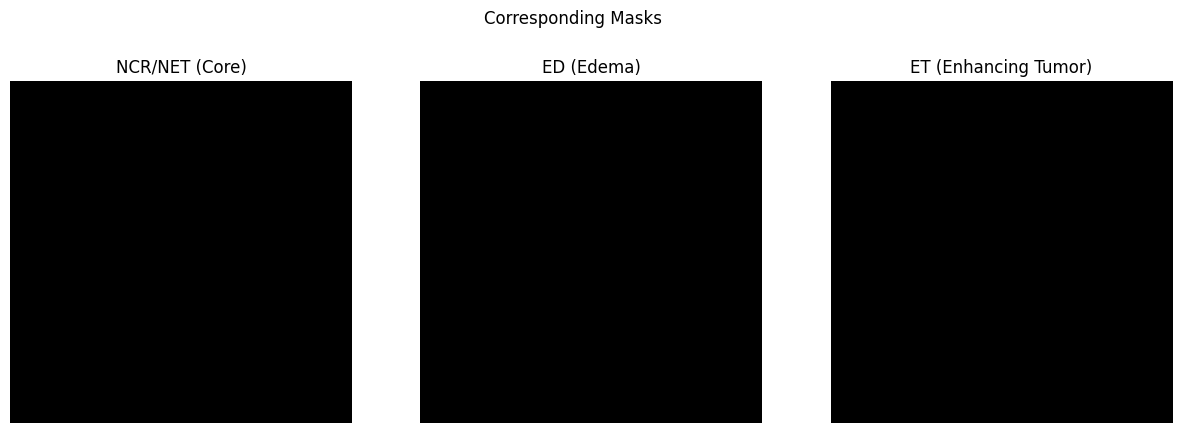

In [57]:
import matplotlib.pyplot as plt
import h5py

modality_names = ["T1", "T1Gd", "T2", "FLAIR"]
mask_labels = ["NCR/NET (Core)", "ED (Edema)", "ET (Enhancing Tumor)"]

def visualize_modalities(image, main_title = ""):
    """Visualizes the four MRI modalities separately."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    for i in range(4):
        ax = axes[i]
        ax.imshow(image[..., i], cmap="gray")
        ax.set_title(modality_names[i])
        ax.axis("off")
    plt.suptitle(main_title)
    plt.show()

def load_h5_file(h5_path):
    """Load both MRI image and segmentation mask from H5 file."""
    with h5py.File(h5_path, "r") as f:
        image = np.array(f["image"])  
        mask = np.array(f["mask"])    
    return image, mask

def visualize_mask(mask, main_title = ""):
    """Visualizes the three tumor regions in the segmentation mask."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        ax = axes[i]
        ax.imshow(mask[..., i], cmap="gray")
        ax.set_title(mask_labels[i])
        ax.axis("off")
    plt.suptitle(main_title)
    plt.show()

random_sample = df.sample(n = 1) #38379 is a good example
sample_row_nbr = random_sample.index[0]
print(f"Sample Number: {sample_row_nbr}")

h5_file_path = random_sample["slice_path"].values[0]

with h5py.File(h5_file_path, "r") as f:
    image_data = f["image"][:]
    mask_data = f["mask"][:]

print("Image shape:", image_data.shape)
print("Mask shape:", mask_data.shape)
visualize_modalities(image_data, "Sample Image Visualized")
visualize_mask(mask_data, "Corresponding Masks")


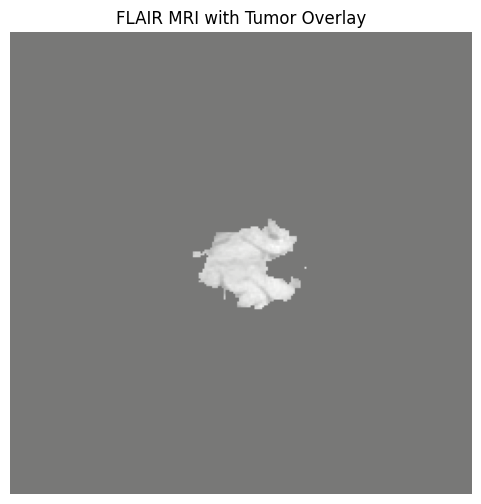

In [58]:
plt.figure(figsize=(6,6))
plt.imshow(image_data[:, :, 1], cmap="gray")  # T2 MRI
plt.imshow(mask_data[:, :, 0], cmap="Reds", alpha=0.2)  # Necrotic Core
plt.imshow(mask_data[:, :, 1], cmap="Greens", alpha=0.2)  # Edema
plt.imshow(mask_data[:, :, 2], cmap="Blues", alpha=0.2)  # Enhancing Tumor
plt.title("FLAIR MRI with Tumor Overlay")
plt.axis("off")
plt.show()


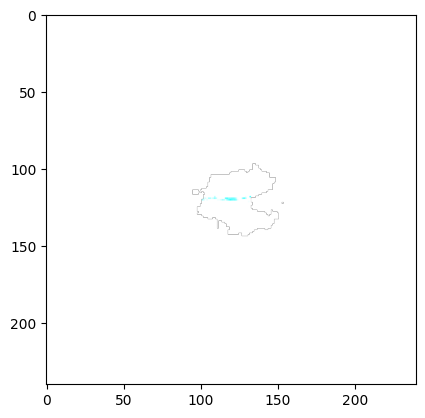

In [59]:
norm = normalize_image(image_data)
plt.imshow(norm)

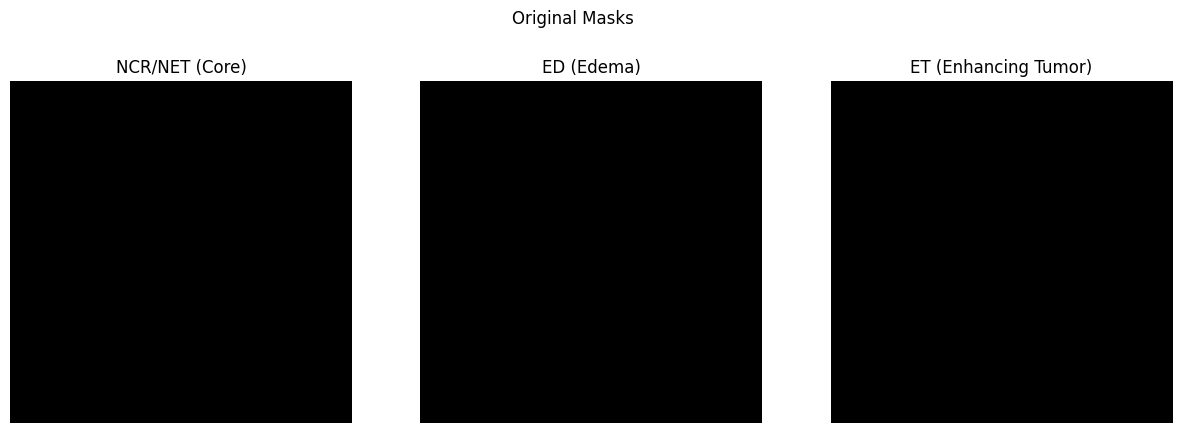

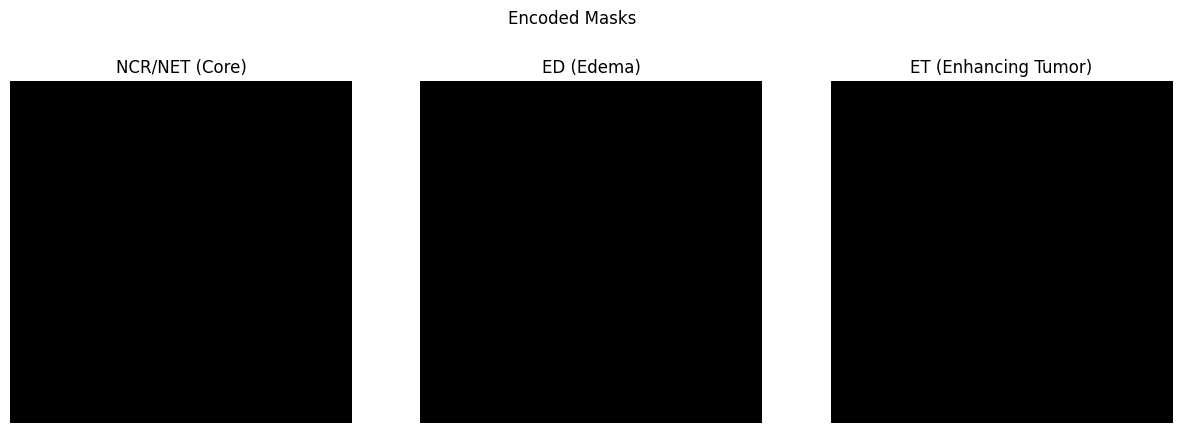

In [60]:
#Visualizing Masks
visualize_mask(mask_data, "Original Masks")
visualize_mask(one_hot_encode(mask_data), "Encoded Masks")

In [61]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

class BratsDataset(Dataset):
    def __init__ (self, df, augmentations=None ):
        """Set the pandas dataframe as the dataset"""
        self.df = df
        self.augmentations = augmentations
        
    def __len__ (self):
        """Get the length of the dataset"""
        return len(self.df)
        
    def __getitem__ (self, idx):
        """Get the relevant item from the dataset"""
        image, mask = load_h5_file(self.df.iloc[idx]["slice_path"])
        normalized_image = normalize_image(image)
        encoded_mask = one_hot_encode(mask)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=normalized_image, mask=encoded_mask)
            normalized_image, encoded_mask = augmented["image"], augmented["mask"]

        # Convert to PyTorch tensors
        image = torch.tensor(normalized_image, dtype=torch.float32).permute(2, 0, 1)  # (4, 240, 240)
        mask = torch.tensor(encoded_mask, dtype=torch.float32).permute(2, 0, 1)    # (3, 240, 240)

        return image, mask


train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.RandomRotate90(p=0.5),  
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(0.001, 0.01), p=0.2),  
    A.Normalize(mean=[0.5]*4, std=[0.5]*4),  
])

# Split dataset (70% train, 15% val, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = BratsDataset(train_df, augmentations=train_transforms)
val_dataset = BratsDataset(val_df)
test_dataset = BratsDataset(test_df)

# Checking lengths
print(f"""Train Dataset Length: {len(train_dataset)}
Validation Dataset Length: {len(val_dataset)}
Test Dataset Length: {len(test_dataset)}""")


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

Train Dataset Length: 40036
Validation Dataset Length: 8579
Test Dataset Length: 8580


In [62]:
# sub-parts of the U-Net model

import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

# full assembly of the sub-parts to form the complete net



class UNet(nn.Module):
    def __init__(self, in_channels = 4, out_channels = 4):
        super(UNet, self).__init__()
        self.inc = inconv(in_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.softmax(x, dim=1)
        return x

model = UNet()
x = torch.randn(2, 4, 256, 256)  # Batch size 2, 4 channels, 256x256 image
y = model(x)
print(y.shape)  # Expected: [2, 3, 256, 256]

torch.Size([2, 4, 256, 256])


In [63]:
from torchsummary import summary

model = UNet(in_channels=4, out_channels=3).to(device)
summary(model, (4, 240, 240))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           2,368
       BatchNorm2d-2         [-1, 64, 240, 240]             128
              ReLU-3         [-1, 64, 240, 240]               0
            Conv2d-4         [-1, 64, 240, 240]          36,928
       BatchNorm2d-5         [-1, 64, 240, 240]             128
              ReLU-6         [-1, 64, 240, 240]               0
       double_conv-7         [-1, 64, 240, 240]               0
            inconv-8         [-1, 64, 240, 240]               0
         MaxPool2d-9         [-1, 64, 120, 120]               0
           Conv2d-10        [-1, 128, 120, 120]          73,856
      BatchNorm2d-11        [-1, 128, 120, 120]             256
             ReLU-12        [-1, 128, 120, 120]               0
           Conv2d-13        [-1, 128, 120, 120]         147,584
      BatchNorm2d-14        [-1, 128, 1

In [64]:
for images, masks in train_loader:  # Assuming DataLoader is set up
    print(f"Batch image shape: {images.shape}, Batch mask shape: {masks.shape}")
    break


Batch image shape: torch.Size([16, 4, 240, 240]), Batch mask shape: torch.Size([16, 3, 240, 240])


In [65]:
"""Hyperparameters for fine tuning"""
LEARNING_RATE = 1e-3
LOSS_BALANCE = 0.5
SCHEDULER_PATIENCE = 3
NUM_OF_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')
PATIENCE_COUNTER = 0
CHECKPOINT_PATH = '/kaggle/working/checkpoints'


In [78]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

In [67]:
# Checkpoint directory
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

log_file = os.path.join(CHECKPOINT_PATH, "training_log.json")
logs = []  # Store logs as a list of dictionaries


In [90]:
def dice_coefficient(preds, targets, smooth=1e-6):
    """
    Computes the Dice Coefficient for multi-class segmentation.
    
    preds: (N, C, H, W) → Model output (softmax probabilities)
    targets: (N, C, H, W) → One-hot encoded ground truth
    """
    num_classes = preds.shape[1]

    # Convert preds to one-hot
    preds = torch.argmax(preds, dim=1)  # (N, H, W)
    preds = nn.functional.one_hot(preds, num_classes=num_classes)  # (N, H, W, C)
    preds = preds.permute(0, 3, 1, 2).float()  # (N, C, H, W)

    intersection = torch.sum(preds * targets, dim=(2, 3))
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets, dim=(2, 3))

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()  # Average across all classes

def iou_score(preds, targets, smooth=1e-6):
    num_classes = preds.shape[1]
    
    # Convert preds to one-hot
    preds = torch.argmax(preds, dim=1)  # (N, H, W)
    preds = nn.functional.one_hot(preds.long(), num_classes=num_classes)  # (N, H, W, C)
    preds = preds.permute(0, 3, 1, 2).float()  # (N, C, H, W)

    # Ensure targets are also one-hot encoded
    targets = nn.functional.one_hot(targets,.long() num_classes=num_classes).permute(0, 3, 1, 2).float()

    intersection = torch.sum(preds * targets, dim=(2, 3))  # Intersection per class
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets, dim=(2, 3)) - intersection  # Union per class

    iou = (intersection + smooth) / (union + smooth)  # IoU for each class
    return iou.mean().item()  # Average across all classes

def calculate_metrics(preds, targets, num_classes):
    """ Compute Precision, Sensitivity (Recall), Specificity per class """
    preds = torch.argmax(preds, dim=1)  # (N, H, W)
    targets = targets.squeeze(1)  # Remove extra channel dimension if exists (N, H, W)

    precision, sensitivity, specificity = [], [], []
    
    for class_id in range(num_classes):
        TP = torch.sum((preds == class_id) & (targets == class_id)).item()
        TN = torch.sum((preds != class_id) & (targets != class_id)).item()
        FP = torch.sum((preds == class_id) & (targets != class_id)).item()
        FN = torch.sum((preds != class_id) & (targets == class_id)).item()

        precision.append(TP / (TP + FP + 1e-6))
        sensitivity.append(TP / (TP + FN + 1e-6))  # Recall
        specificity.append(TN / (TN + FP + 1e-6))

    # Average metrics over all classes
    avg_precision = np.mean(precision)
    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return avg_precision, avg_sensitivity, avg_specificity


SyntaxError: invalid syntax (<ipython-input-90-3b1d5859554d>, line 30)

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [92]:
import torch
import torch.nn as nn
import os
import logging
from tqdm import tqdm
import numpy as np

# Setup logging
logging.basicConfig(filename='training_metrics.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# Model, optimizer, criterion setup
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on the validation set
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    metrics = {
        'val_dice': 0,
        'val_iou': 0,
        'val_precision': 0,
        'val_sensitivity': 0,
        'val_specificity': 0
    }
    
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            masks_class = torch.tensor(mask_to_class(masks.cpu().numpy()), device=device).long()

            # Calculate loss
            loss = criterion(outputs, masks_class)
            val_loss += loss.item()
            
            # Accumulate metrics
            metrics['val_dice'] += dice_coefficient(outputs, masks)
            metrics['val_iou'] += iou_score(outputs, masks)
            metrics['val_precision'], metrics['val_sensitivity'], metrics['val_specificity'] = calculate_metrics(outputs, masks, 3)
    
    # Average metrics over the validation set
    num_batches = len(val_loader)
    for key in metrics:
        metrics[key] /= num_batches
    
    val_loss /= num_batches
    return val_loss, metrics

# Training loop with checkpoints and early stopping
for epoch in range(1):  # Loop over epochs
    model.train()

    # Initialize training metrics
    metrics = {
        'train_loss': 0,
        'train_dice': 0,
        'train_iou': 0,
        'train_precision': 0,
        'train_sensitivity': 0,
        'train_specificity': 0
    }

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{5} - Training"):
        images, masks = images.to(device), masks.to(device)  # Move to GPU
        
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass

        # Convert multi-channel masks to class indices
        masks_class = torch.tensor(mask_to_class(masks.cpu().numpy()), device=device).long()  # Convert to class indices

        # Compute loss using CrossEntropyLoss
        loss = criterion(outputs, masks_class)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate training metrics
        metrics['train_loss'] += loss.item()
        metrics['train_dice'] += dice_coefficient(outputs, masks)
        metrics['train_iou'] += iou_score(outputs, masks)
        metrics['train_precision'], metrics['train_sensitivity'], metrics['train_specificity'] = calculate_metrics(outputs, masks, 3)

    # Average metrics over the epoch
    num_batches = len(train_loader)
    for key in metrics:
        metrics[key] /= num_batches

    # Validate the model on the validation set
    val_loss, val_metrics = validate(model, val_loader, criterion)
    
    # Log metrics
    logging.info(f"Epoch {epoch+1}/{5} - "
                 f"Train Loss: {metrics['train_loss']:.4f}, Train Dice: {metrics['train_dice']:.4f}, "
                 f"Train IoU: {metrics['train_iou']:.4f}, Train Precision: {metrics['train_precision']:.4f}, "
                 f"Train Sensitivity: {metrics['train_sensitivity']:.4f}, Train Specificity: {metrics['train_specificity']:.4f}, "
                 f"Val Loss: {val_loss:.4f}, Val Dice: {val_metrics['val_dice']:.4f}, "
                 f"Val IoU: {val_metrics['val_iou']:.4f}, Val Precision: {val_metrics['val_precision']:.4f}, "
                 f"Val Sensitivity: {val_metrics['val_sensitivity']:.4f}, Val Specificity: {val_metrics['val_specificity']:.4f}")

    # Checkpoint saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience
        torch.save(model.state_dict(), 'best_model.pth')  # Save checkpoint
        logging.info(f"Model checkpoint saved at epoch {epoch+1}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        logging.info(f"Early stopping at epoch {epoch+1}")
        break

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{5} - Loss: {metrics['train_loss']:.4f}, "
          f"Dice: {metrics['train_dice']:.4f}, IoU: {metrics['train_iou']:.4f}, "
          f"Precision: {metrics['train_precision']:.4f}, "
          f"Sensitivity: {metrics['train_sensitivity']:.4f}, "
          f"Specificity: {metrics['train_specificity']:.4f}")
    print(f"Validation - Loss: {val_loss:.4f}, Dice: {val_metrics['val_dice']:.4f}, "
          f"IoU: {val_metrics['val_iou']:.4f}, Precision: {val_metrics['val_precision']:.4f}, "
          f"Sensitivity: {val_metrics['val_sensitivity']:.4f}, Specificity: {val_metrics['val_specificity']:.4f}")


Epoch 1/5 - Training:   0%|          | 0/2503 [00:01<?, ?it/s]


RuntimeError: one_hot is only applicable to index tensor of type LongTensor.